In [1]:
import abm
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as p9

# QSP Designer Import

## QSP Designer Model

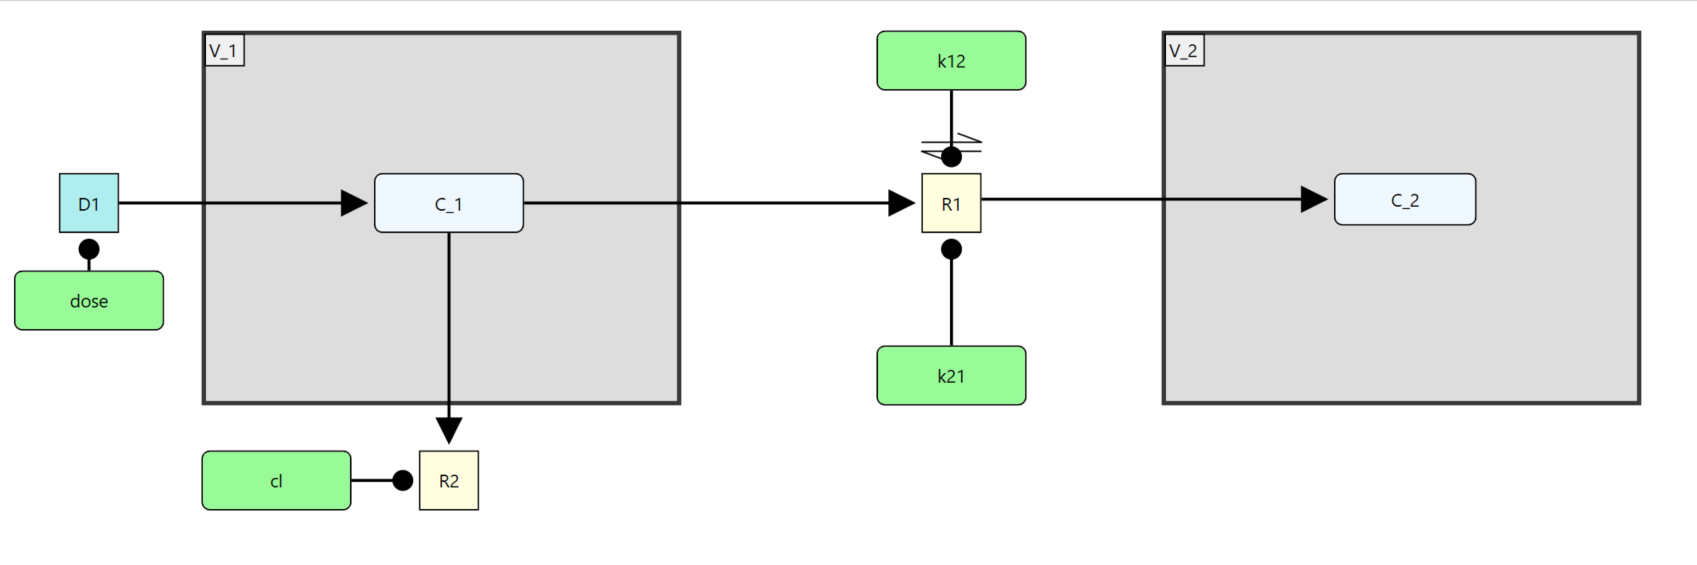

Model is saved as `basic_model.qsp`

### QSP Designer Outputs

Simple 2-compartment model in QSP Designer, a 1 mg bolus dose `D1` is administered to `V_1` at `t = 0` and simulated for 24 hours. `QSPStates.csv` is the output csv file from QSP Designer.

Text(0, 0.5, 'Concentration (mg / L)')

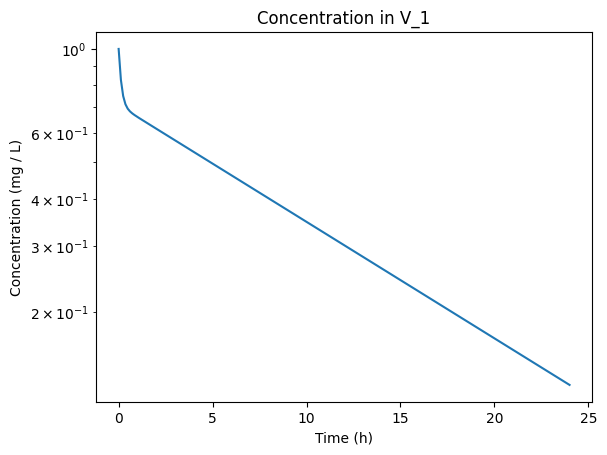

In [2]:
designer_out = pd.read_csv("QSPStates.csv")
designer_out.columns = ["id", "t", "C_1", "C_2"]

plt.plot(designer_out.t, designer_out.C_1)
plt.yscale("log")
plt.title("Concentration in V_1")
plt.xlabel("Time (h)")
plt.ylabel("Concentration (mg / L)")

Text(0, 0.5, 'Concentration (mg / L)')

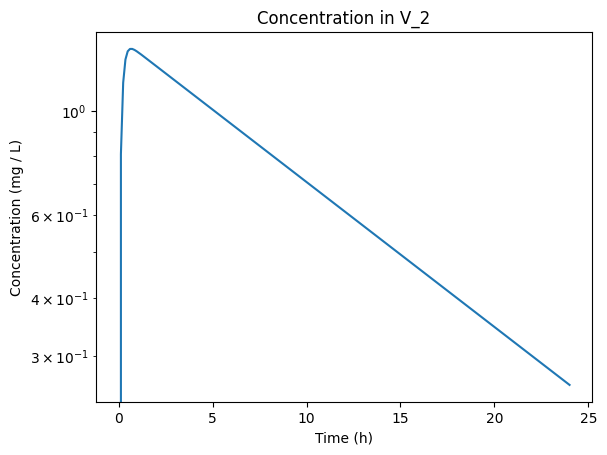

In [3]:
plt.plot(designer_out.t, designer_out.C_2)
plt.yscale("log")
plt.title("Concentration in V_2")
plt.xlabel("Time (h)")
plt.ylabel("Concentration (mg / L)")

## Running in Notebook

### Basic Model Run

We can run the model in Notebook using the normal `simulate` interface. The Designer model is passed using the `models` argument.

In [4]:
# As in Designer, model is simulated for 1 mg dose for 24 hours at 200 timepoints
times = abm.linspace(0, 24, 200, "hr")
parameters = pd.DataFrame(columns=["parameter", "value", "unit"], data=[["dose", 1.0, "mg"]])
sim = abm.simulate(models="basic_model.qsp", parameters=parameters, times=times)
output_df = sim.to_pandas(tall_outputs=False)

Total: 0, Running: 0, Succeeded: 0, Failed: 0

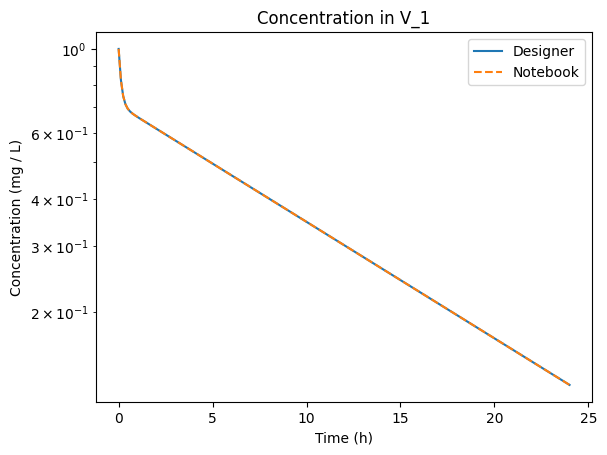

In [5]:
plt.plot(designer_out.t, designer_out.C_1, label="Designer")

plt.plot(output_df.t, output_df.C_1, label="Notebook", linestyle="dashed")
plt.yscale("log")
plt.title("Concentration in V_1")
plt.xlabel("Time (h)")
plt.ylabel("Concentration (mg / L)")

plt.legend()

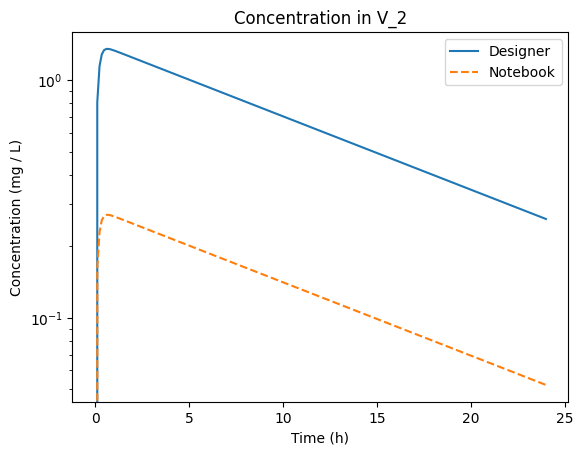

In [6]:
plt.plot(designer_out.t, designer_out.C_2, label="Designer")

plt.plot(output_df.t, output_df.C_2, label="Notebook", linestyle="dashed")
plt.yscale("log")
plt.title("Concentration in V_2")
plt.xlabel("Time (h)")
plt.ylabel("Concentration (mg / L)")

plt.legend()

`C_2` is an amount in Notebook output, but a concentration in Designer. Compartment volumes are part of the simulation output so we can just divide through.

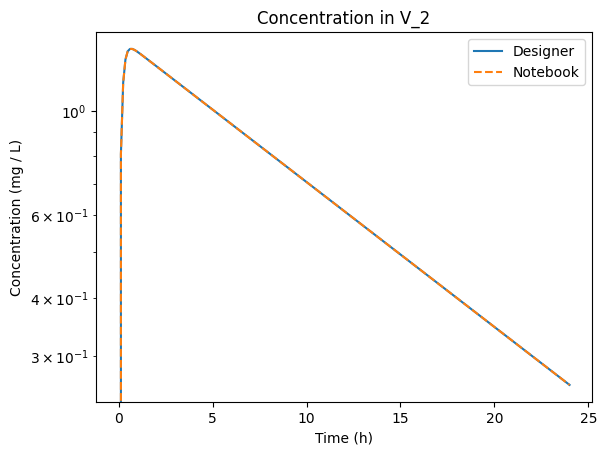

In [7]:
plt.plot(designer_out.t, designer_out.C_2, label="Designer")

plt.plot(output_df.t, output_df.C_2 / output_df.V_2, label="Notebook", linestyle="dashed")
plt.yscale("log")
plt.title("Concentration in V_2")
plt.xlabel("Time (h)")
plt.ylabel("Concentration (mg / L)")

plt.legend()

### Further Example

Here we use the parameter table to simulate 3 dosing regimes, `1, 2 and 3 mg`

In [8]:
multi_params = pd.DataFrame(
    columns=["dose_id", "parameter", "value", "unit"], 
    data=[[0, "dose", 1.0, "mg"], [1, "dose", 2.0, "mg"], [2, "dose", 3.0, "mg"]]
)
simulations = pd.DataFrame(columns = ["dose_id"], data=multi_params.dose_id)

In [9]:
multi_sim = abm.simulate(models="basic_model.qsp", simulations=simulations, parameters=multi_params, times=times)
multi_df = multi_sim.to_pandas(tall_outputs=False)

Total: 0, Running: 0, Succeeded: 0, Failed: 0

/opt/pixi/cache/envs/qsp-notebook-training-3044541073508600004/envs/default/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


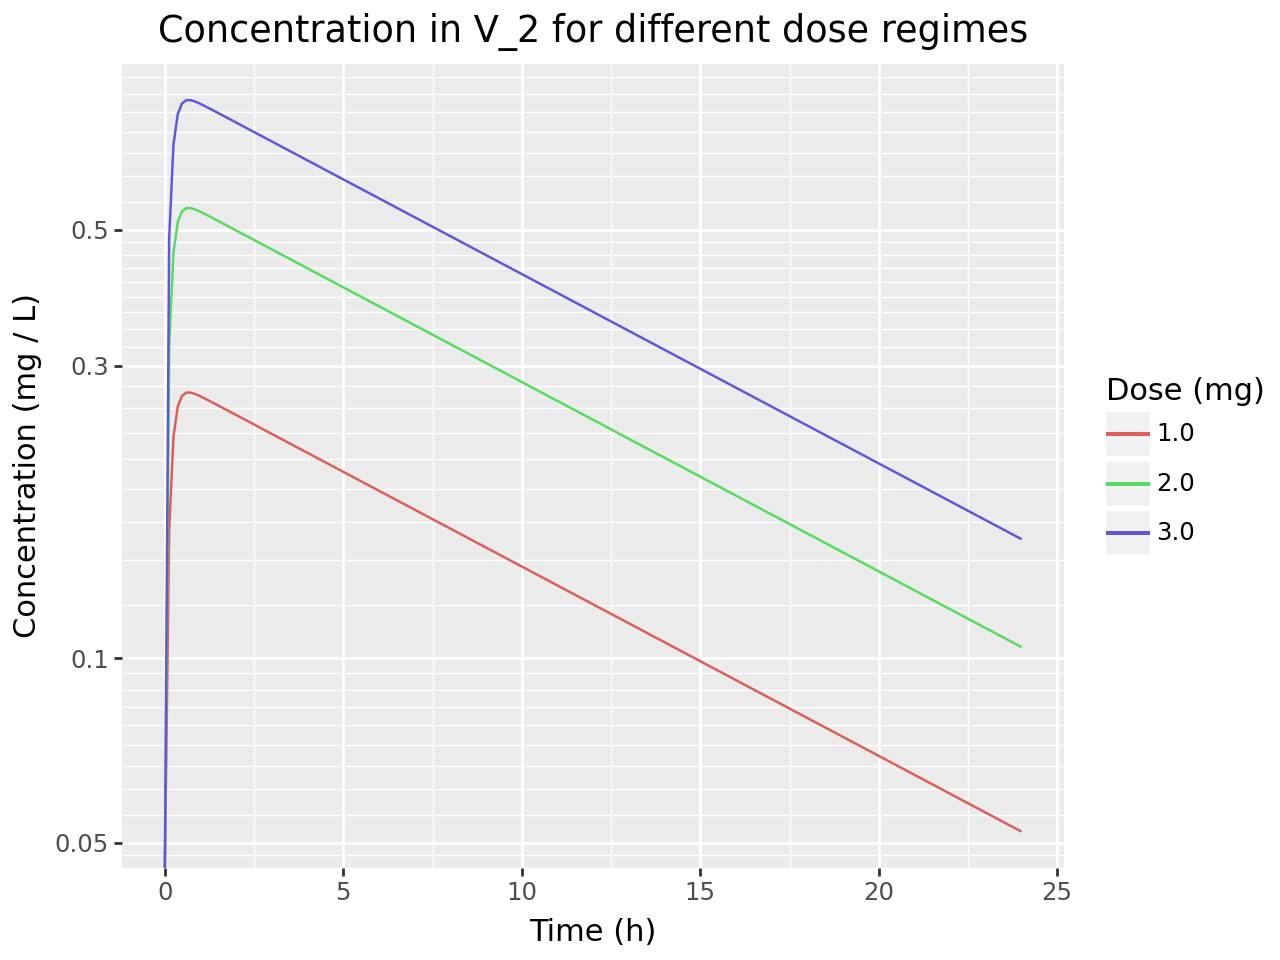

In [10]:
(
    p9.ggplot(multi_df, p9.aes(x="t", y="C_2", color="factor(dose)", group="dose")) + 
    p9.ggtitle("Concentration in V_2 for different dose regimes") + 
    p9.geom_line() +
    p9.scale_y_log10() + 
    p9.labs(x="Time (h)", y = "Concentration (mg / L)", color="Dose (mg)")
)